--------------------
# Homework
- ออกแบบโมเดลแบบ โดยใช้ InceptionV3 block (ภาพขวา) กับฟีเจอร์ ที่ออกจาก conv-pool ชั้นแรก
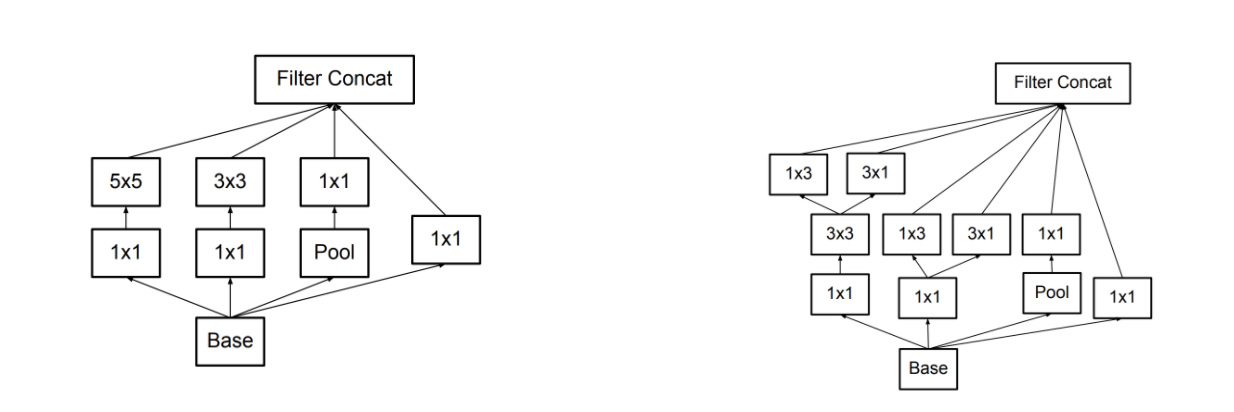

- [source dataset = Caltech101] ฝึกฝน pretained model บนข้อมูล source จำนวนวนรอบมากกว่าหรือเท่ากับ 10 รอบ (>= 10 epoches)
- [target dataset = STL10] จำนวนวนซ้ำที่ 5 รอบ (5 epoches) สำหรับการฝึกฝนบนข้อมูล target

\
1.) [Pretraining part] เทียบโมเดลที่ฝึกฝน Caltech101 ด้วย InceptionV1 กับ InceptionV3 ทั้งด้านประสิทธิภาพและทรัพยากรที่ใช้\
2.) [Resume training] ฝึกฝน STL10 ที่ใช้ pre-trained weight จาก Caltech101 เรียนในทุกเลเยอร์ (learning rate เดียวกันทุกเลเยอร์) คล้ายกับการบ้าน W4-2\
3.) [Fine-tune training] ฝึกฝน STL10 ที่ใช้ pre-trained weight จาก Caltech101 แบบ fine-tune weight บางเลเยอร์ (learning rate ค่อยปรับไล่ระดับ)\
4.)  เปรีบเทียบผลลัพธ์เชิงปริมาณและการแสดงผลทั้ง Quantitative (Accuracy, loss, precision, recall, F1-score, NMI/RI scores, resource usage) and visualization results (t-SNE, plot) จากข้อ 1 และ 2

In [1]:
pip install gdown

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from datetime import datetime
import gdown

transform = transforms.Compose(
        [transforms.Resize((32, 32)),
         transforms.Grayscale(num_output_channels=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training_set = torchvision.datasets.Caltech101('./data', transform=transform, download=True)
validation_set = torchvision.datasets.Caltech101('./data', transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)


# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=68ada7af-34e2-4a5b-8af1-e317d956b709
To: /content/data/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:00<00:00, 189MB/s]


Extracting ./data/caltech101/101_ObjectCategories.tar.gz to ./data/caltech101


Downloading...
From (original): https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
From (redirected): https://drive.usercontent.google.com/download?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m&confirm=t&uuid=71d83e5f-5dd3-473b-b900-6bc567186649
To: /content/data/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 195MB/s]


Extracting ./data/caltech101/Annotations.tar to ./data/caltech101
Files already downloaded and verified
Training set has 8677 instances
Validation set has 8677 instances


In [3]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [4]:
pip install torchsummary

In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

#---Variable initialization---
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#-----------------------------

#---CNN---
class InceptionBlockV3(nn.Module):
    def __init__(self, in_channels):
        super(InceptionBlockV3, self).__init__()

        # Branch 1: 1x1 -> 3x3 -> 1x3 Convolutions
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(True)
        )

        # Branch 2: 1x1 -> 3x3 -> 3x1 Convolutions
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(True)
        )

        # Branch 3: 1x1 -> 1x3 Convolutions
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(True)
        )

        # Branch 4: 1x1 -> 3x1 Convolutions
        self.branch4 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(True)
        )

        # Branch 5: Pooling -> 1x1 Convolution
        self.branch5 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, 64, kernel_size=1),
            nn.ReLU(True)
        )

        # Branch 6: 1x1 Convolution
        self.branch6 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=1),
            nn.ReLU(True)
        )

    def forward(self, x):
        # Apply each branch
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        branch5 = self.branch5(x)
        branch6 = self.branch6(x)

        # Concatenate along the channel dimension
        outputs = [branch1, branch2, branch3, branch4, branch5, branch6]
        return torch.cat(outputs, 1)

class HandwrittenModel(nn.Module):
    def __init__(self):
        super(HandwrittenModel, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(64)
        self.inception = InceptionBlockV3(64)  # Input channels adjusted to 64 after first conv layer

        # Adjusted the fully connected layers accordingly
        # After inception block, the number of channels is 384 and input is downsampled.
        self.fc1 = nn.Linear(384 * 16 * 16, 512)  # 32x32 becomes 16x16 after max pooling
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 101)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.pool(x)
        x = self.inception(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model initialization
model = HandwrittenModel().to(device)

#---summary---
summary(model, (3, 32, 32))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
EPOCHS = 10
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

t_0_accelerated = time.time()
stored_lbs_tar = torch.empty(0, dtype=torch.float32)
stored_preds_tar = torch.empty(0, dtype=torch.float32)

for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    model.train(True)

    for i, data in enumerate(training_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    valid_loss, valid_correct = 0, 0
    model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += vloss.item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()

            # --- Store the labels and predictions ---
            stored_lbs_tar = torch.cat((stored_lbs_tar, vlabels.cpu()), 0)  # Move to CPU before storing
            _, prediction_t = torch.max(voutputs, 1)
            stored_preds_tar = torch.cat((stored_preds_tar, prediction_t.cpu()), 0)

    training_logs["validate_loss"].append(valid_loss / len(validation_loader))
    training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    print(f"Epoch {epoch+1} | Train Loss: {training_logs['train_loss'][-1]:.5f}, Train Acc: {training_logs['train_acc'][-1]:.5f} | "
          f"Val Loss: {training_logs['validate_loss'][-1]:.5f}, Val Acc: {training_logs['validate_acc'][-1]:.5f}")

    if valid_loss < best_vloss:
        best_vloss = valid_loss
        if not os.path.exists(path_save_cp):
            os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_pretrainedmodel.pth')

t_end_accelerated = time.time() - t_0_accelerated
print(f"Time for accelerated CUDA training (device:{device}): {t_end_accelerated} sec")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           2,080
              ReLU-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          12,352
              ReLU-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           2,080
             ReLU-11           [-1, 32, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          18,496
             ReLU-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

{'train_loss': [3.5363960483456185, 2.682944633245029, 2.1249920066109897, 1.7456989543543335, 1.4432277820496708, 1.205012239556945, 0.9879507276728667, 0.8082080589089384, 0.6106736569032485, 0.4668244962986991], 'train_acc': [0.2692174714763167, 0.4106257923245361, 0.5078944335599862, 0.5854558026967847, 0.644001382966463, 0.7017402327993546, 0.7499135645960585, 0.7903653336406592, 0.8386539126426185, 0.878644692866198], 'validate_loss': [3.0241302435113115, 2.2786800328358168, 1.7830499631056351, 1.405414222275622, 1.1522925225188954, 0.920749575883342, 0.8018381278183178, 0.5480491658336711, 0.47287291025333156, 0.3081506160010945], 'validate_acc': [0.35507663939149475, 0.4758557104990204, 0.574622565402789, 0.6690100265068573, 0.7272098651607698, 0.7754984441627291, 0.7999308516768469, 0.8704621412930736, 0.8899389189812147, 0.9239368445315201]}


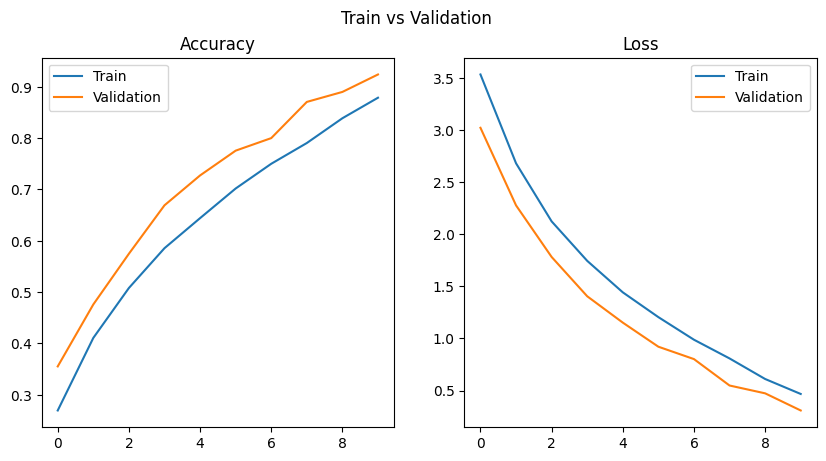

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()
plot_graph(training_logs)
print(training_logs)

In [8]:
# https://github.com/fyse-nassar/Malware-Family-Classification/blob/master/Malware%20Opcode%20Ngrams%20Generator.ipynb
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    Normalization can be applied by setting `normalize=True`.
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)    #office-31
    plt.xticks(tick_marks, classes, rotation=20, fontsize=12)    #office-home
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize==True:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+1)
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    # print(cm)

    formated = '.2f' if normalize==True else 'd'
    #---manual---
    thresh = cm.max() / 2.
    #thresh > 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], formated),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #---sns---
    #df_cm = pd.DataFrame(cm, classes, classes)
    #sns.heatmap(df_cm, annot=True, fmt=formated, cmap=cmap)

    plt.gcf().set_size_inches(8, 6)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.margins(2,2)
    plt.tight_layout()



"""
  Args: Collect feature
  Ref: https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/__init__.py#L7
"""
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import tqdm
import os.path as osp


def collect_feature(data_loader: DataLoader, feature_extractor: nn.Module,
                                   device: torch.device, max_num_features=None) -> torch.Tensor:
    """
    Fetch data from `data_loader`, and then use `feature_extractor` to collect features
    Args:
        data_loader (torch.utils.data.DataLoader): Data loader.
        feature_extractor (torch.nn.Module): A feature extractor.
        device (torch.device)
        max_num_features (int): The max number of features to return
    Returns:
        Features in shape (min(len(data_loader), max_num_features), :math:`|\mathcal{F}|`).
    """
    feature_extractor.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
            images = images.to(device)
            features = feature_extractor(images)
            if isinstance(features, tuple):
                # Check if it's a tuple (common when using certain pre-trained models)
                # You may want to select the feature tensor you need from the tuple
                # For example, if the feature tensor is the first element of the tuple:
                feature_tensor = features[0]
                feature_tensor = feature_tensor.to(device)  # Move the tensor to CPU
            else:
                feature_tensor = features.to(device)  # Move the tensor to CPU

            all_features.append(feature_tensor)
            all_labels.append(target)

    return torch.cat(all_features, dim=0),\
        torch.cat(all_labels, dim=0) # Concatenate the list of feature tensors

    #        all_features.append(features)
    #        if max_num_features is not None and i >= max_num_features:
    #            break
    #return torch.cat(all_features, dim=0)


# ref https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/__init__.py#L7
import torch
import matplotlib

matplotlib.use('Agg')
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col


def visualize(source_feature: torch.Tensor, target_feature: torch.Tensor,
              filename: str, source_color='r', target_color='b'):
    """
    Visualize features from different domains using t-SNE.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        filename (str): the file name to save t-SNE
        source_color (str): the color of the source features. Default: 'r'
        target_color (str): the color of the target features. Default: 'b'
    """
    source_feature = source_feature.cpu().numpy()
    target_feature = target_feature.cpu().numpy()
    features = np.concatenate([source_feature, target_feature], axis=0)

    # map features to 2-d using TSNE
    X_tsne = TSNE(n_components=2, random_state=33).fit_transform(features)

    # domain labels, 1 represents source while 0 represents target
    domains = np.concatenate((np.ones(len(source_feature)), np.zeros(len(target_feature))))

    # visualize using matplotlib
    plt.figure(figsize=(10, 10))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=domains, cmap=col.ListedColormap([source_color, target_color]), s=20)  #default: s=2
    plt.savefig(filename)

import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as col

"""
  Arg: t-SNE for class clustering visualization
"""

def visualize_class_n_domain(source_feature: torch.Tensor, target_feature: torch.Tensor, source_labels: torch.Tensor, target_labels: torch.Tensor, filename: str, source_color='r', target_color='b'):
    """
    Visualize features from different domains using t-SNE.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        source_labels (tensor): class labels for source domain features
        target_labels (tensor): class labels for target domain features
        filename (str): the file name to save t-SNE
        source_color (str): the color of the source features. Default: 'r'
        target_color (str): the color of the target features. Default: 'b'
    """
    source_feature = source_feature.cpu().numpy()
    target_feature = target_feature.cpu().numpy()
    source_labels = source_labels.cpu().numpy()
    target_labels = target_labels.cpu().numpy()

    # Combine features and labels
    features = np.concatenate([source_feature, target_feature], axis=0)
    labels = np.concatenate([source_labels, target_labels], axis=0)
    domains = np.concatenate((np.ones(len(source_feature)), np.zeros(len(target_feature))))

    # Map features to 2-D using t-SNE
    X_tsne = TSNE(n_components=2, random_state=33).fit_transform(features)

    # Visualize using matplotlib
    plt.figure(figsize=(10, 10))

    # Get unique class labels
    unique_labels = np.unique(labels)

    # Create a color map for classes
    #cmap = plt.get_cmap('tab20', len(unique_labels))
    cmap_s = plt.get_cmap('nipy_spectral', len(unique_labels))
    cmap_r = plt.get_cmap('gist_rainbow', len(unique_labels))

    # Plot data points for each class and domain
    for label in unique_labels:
        for domain in [0, 1]:
            mask = (labels == label) & (domains == domain)
            plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=cmap_s(label), s=10,
                        #label=f"Class {label}, Domain {domain}",
                        )

    plt.legend()
    plt.savefig(filename)

# Example usage



from torch.utils.data import TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import SGD

#from ..metric import binary_accuracy

"""
  Args: A-distance computation
  Ref: https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/a_distance.py
"""

def binary_accuracy(output: torch.Tensor, target: torch.Tensor) -> float:
    """Computes the accuracy for binary classification"""
    with torch.no_grad():
        batch_size = target.size(0)
        pred = (output >= 0.5).float().t().view(-1)
        correct = pred.eq(target.view(-1)).float().sum()
        correct.mul_(100. / batch_size)
        return correct

class ANet(nn.Module):
    def __init__(self, in_feature):
        super(ANet, self).__init__()
        self.layer = nn.Linear(in_feature, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer(x)
        x = self.sigmoid(x)
        return x

class AverageMeter(object):
    r"""Computes and stores the average and current value.
    Examples::
        >>> # Initialize a meter to record loss
        >>> losses = AverageMeter()
        >>> # Update meter after every minibatch update
        >>> losses.update(loss_value, batch_size)
    """
    def __init__(self, name: str, fmt):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        if self.count > 0:
            self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

def calculate(source_feature: torch.Tensor, target_feature: torch.Tensor,
              device, progress=True, training_epochs=10):
    """
    Calculate the :math:`\mathcal{A}`-distance, which is a measure for distribution discrepancy.
    The definition is :math:`dist_\mathcal{A} = 2 (1-2\epsilon)`, where :math:`\epsilon` is the
    test error of a classifier trained to discriminate the source from the target.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        device (torch.device)
        progress (bool): if True, displays a the progress of training A-Net
        training_epochs (int): the number of epochs when training the classifier
    Returns:
        :math:`\mathcal{A}`-distance
    """
    source_label = torch.ones((source_feature.shape[0], 1))
    target_label = torch.zeros((target_feature.shape[0], 1))
    feature = torch.cat([source_feature, target_feature], dim=0)
    label = torch.cat([source_label, target_label], dim=0)

    dataset = TensorDataset(feature, label)
    length = len(dataset)
    train_size = int(0.8 * length)
    val_size = length - train_size

    # Specify a random generator for CUDA
    generator = torch.Generator(device='cpu')

    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size], generator)
    train_loader = DataLoader(train_set, batch_size=2, shuffle=True, generator=generator)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False, generator=generator)

    anet = ANet(feature.shape[1]).to(device)
    optimizer = SGD(anet.parameters(), lr=0.01)
    a_distance = 2.0
    for epoch in range(training_epochs):
        anet.train()
        for (x, label) in train_loader:
            x = x.to(device)
            label = label.to(device)
            anet.zero_grad()
            y = anet(x)
            loss = F.binary_cross_entropy(y, label)
            loss.backward()
            optimizer.step()

        anet.eval()
        meter = AverageMeter("accuracy", ":4.2f")
        with torch.no_grad():
            for (x, label) in val_loader:
                x = x.to(device)
                label = label.to(device)
                y = anet(x)
                acc = binary_accuracy(y, label)
                meter.update(acc, x.shape[0])
        error = 1 - meter.avg / 100
        a_distance = 2 * (1 - 2 * error)
        if progress:
            print("epoch {} accuracy: {} A-dist: {}".format(epoch, meter.avg, a_distance))

    return a_distance



##########################################################################################










source_feature, s_labels = collect_feature(training_loader, model, device)
target_feature, t_labels = collect_feature(validation_loader, model, device)


# --- Confusion matrix, F1-score, precision, recall, NMI/RI scores
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, normalized_mutual_info_score, adjusted_rand_score#, f1_score
# Class labels
pos_labels = np.arange(10)
lb_classes = tuple(str(i) for i in range(102))

lb = stored_lbs_tar.cpu()
prd = stored_preds_tar.cpu()
#---confusion matrix
cm_target = confusion_matrix(y_true=lb,
                            y_pred=prd,
                            labels=pos_labels,
                            normalize='true',
                            )
plt.figure()
plt.rcParams.update({'font.size': 10, 'figure.figsize': (2,2)})
plot_confusion_matrix(cm_target,
                        classes=lb_classes,
                        normalize=True,
                        title='Conf. Mat. w.r.t. CIFAR-10 ds',
                        cmap=plt.cm.binary #Blues_r
                        )    #Blues_r = off-white diagonal
#---F1-score/Precision/Recall scores
print("Precision/Recall/F-beta score:", precision_recall_fscore_support(lb, prd, average='weighted', zero_division=0,
                                          beta=1.0)) #labels=label_classes))
#---Normalized Mutual Information (NMI) score
nmi_score = normalized_mutual_info_score(labels_true=lb,
                                        labels_pred=prd,
                                        average_method='arithmetic',
                                        )
#---Rand Index (RI) score
ri_score = adjusted_rand_score(labels_true=lb,
                                labels_pred=prd,
                                )
print(f"NMI score: {nmi_score}, RI score: {ri_score}")

visualize_class_n_domain(source_feature, target_feature, s_labels, t_labels, 'tsne_plot.png')

# --- plot t-SNE
if not os.path.exists('./output/'): os.mkdir('./output/')
tSNE_filename = osp.join('./output/', 'W5-1_tSNE.png')
#visualize_class_n_domain(source_feature, source_feature, s_labels, s_labels, tSNE_filename)    # single-domain multi-class rep
visualize_class_n_domain(source_feature, target_feature, s_labels, t_labels, tSNE_filename)    # two-domain multi-class rep
print("Saving t-SNE to", tSNE_filename)

100%|██████████| 543/543 [00:16<00:00, 33.57it/s]


Precision/Recall/F-beta score: (0.7310838890309637, 0.7061542007606315, 0.7028236490198713, None)
NMI score: 0.6301522157195287, RI score: 0.7866472922798531


<ipython-input-8-f8129efd76fc>:223: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=cmap_s(label), s=10,
<ipython-input-8-f8129efd76fc>:223: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=cmap_s(label), s=10,


Saving t-SNE to ./output/W5-1_tSNE.png


In [9]:
training_set = torchvision.datasets.STL10('./data', transform=transform, download=True)
validation_set = torchvision.datasets.STL10('./data', transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)


# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 2640397119/2640397119 [01:36<00:00, 27308086.69it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
Training set has 5000 instances
Validation set has 5000 instances


In [10]:
# Model init
new_model_head = HandwrittenModel().to(device)
#---load and replace new hidden layers---
load_pretrained = True
if load_pretrained:
  checkpoint = torch.load(path_save_cp+f'best_pretrainedmodel.pth')
  new_model_head.load_state_dict(checkpoint, strict=False)
new_model_head.fc2 = nn.Linear(512, 32).to(device)
new_model_head.fc3 = nn.Linear(32, 10).to(device)
#---------------------------------------
summary(new_model_head, (3, 32, 32))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimization for some layers, out of them got freezing or fine-tuning with a few lr
lr = 5e-3
optimizer = torch.optim.SGD(new_model_head.parameters(),lr=lr,momentum=0.9)

epoch_number = 0

EPOCHS_finetune = 5
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

<ipython-input-10-1be187a85e88>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_save_cp+f'best_pretrainedmodel.pth')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           2,080
              ReLU-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          12,352
              ReLU-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           2,080
             ReLU-11           [-1, 32, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          18,496
             ReLU-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

In [11]:
stored_lbs_tar = torch.empty(0, dtype=torch.float32)
stored_preds_tar = torch.empty(0, dtype=torch.float32)

t_0_accelerated = time.time()
for epoch in range(EPOCHS_finetune):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    new_model_head.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = new_model_head(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    new_model_head.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = new_model_head(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

            # --- Store the labels and predictions ---
        stored_lbs_tar = torch.cat((stored_lbs_tar, vlabels.cpu()), 0)  # Move to CPU before storing
        _, prediction_t = torch.max(voutputs, 1)
        stored_preds_tar = torch.cat((stored_preds_tar, prediction_t.cpu()), 0)

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(new_model_head.state_dict(), path_save_cp+f'W5-1_best_resumemodel_{EPOCHS_finetune}ep.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec")


Epochs 1   train loss 1.78984 train acc 0.30860 validate loss 1.51585 validate acc 0.41960
--------------------------------------------------------------------------------
Epochs 2   train loss 1.43282 train acc 0.46900 validate loss 1.20661 validate acc 0.56340
--------------------------------------------------------------------------------
Epochs 3   train loss 1.13991 train acc 0.57540 validate loss 0.90752 validate acc 0.66520
--------------------------------------------------------------------------------
Epochs 4   train loss 0.83425 train acc 0.70220 validate loss 0.63776 validate acc 0.77840
--------------------------------------------------------------------------------
Epochs 5   train loss 0.55053 train acc 0.80420 validate loss 0.28051 validate acc 0.91920
--------------------------------------------------------------------------------
Time consumption for accelerated CUDA training (device:cuda): 67.18283748626709 sec


In [12]:
plot_graph(training_logs)

In [13]:
source_feature, s_labels = collect_feature(training_loader, new_model_head, device)
target_feature, t_labels = collect_feature(validation_loader, new_model_head, device)


# --- Confusion matrix, F1-score, precision, recall, NMI/RI scores
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, normalized_mutual_info_score, adjusted_rand_score#, f1_score
# Class labels
pos_labels = np.arange(10)
lb_classes = ('0', '1', '2', '3', '4', '5', '6' ,'7', '8', '9')

lb = stored_lbs_tar.cpu()
prd = stored_preds_tar.cpu()
#---confusion matrix
cm_target = confusion_matrix(y_true=lb,
                            y_pred=prd,
                            labels=pos_labels,
                            normalize='true',
                            )
plt.figure()
plt.rcParams.update({'font.size': 10, 'figure.figsize': (2,2)})
plot_confusion_matrix(cm_target,
                        classes=lb_classes,
                        normalize=True,
                        title='Conf. Mat. w.r.t. CIFAR-10 ds',
                        cmap=plt.cm.binary #Blues_r
                        )    #Blues_r = off-white diagonal
#---F1-score/Precision/Recall scores
print("Precision/Recall/F-beta score:", precision_recall_fscore_support(lb, prd, average='weighted', zero_division=0,
                                          beta=1.0)) #labels=label_classes))
#---Normalized Mutual Information (NMI) score
nmi_score = normalized_mutual_info_score(labels_true=lb,
                                        labels_pred=prd,
                                        average_method='arithmetic',
                                        )
#---Rand Index (RI) score
ri_score = adjusted_rand_score(labels_true=lb,
                                labels_pred=prd,
                                )
print(f"NMI score: {nmi_score}, RI score: {ri_score}")

visualize_class_n_domain(source_feature, target_feature, s_labels, t_labels, 'tsne_plot.png')

# --- plot t-SNE
if not os.path.exists('./output/'): os.mkdir('./output/')
tSNE_filename = osp.join('./output/', 'W5-1_tSNE_resume.png')
#visualize_class_n_domain(source_feature, source_feature, s_labels, s_labels, tSNE_filename)    # single-domain multi-class rep
visualize_class_n_domain(source_feature, target_feature, s_labels, t_labels, tSNE_filename)    # two-domain multi-class rep
print("Saving t-SNE to", tSNE_filename)

100%|██████████| 313/313 [00:03<00:00, 79.05it/s]


Precision/Recall/F-beta score: (0.8375, 0.65, 0.7194444444444444, None)
NMI score: 0.6512893766524958, RI score: 0.41847826086956524


<ipython-input-8-f8129efd76fc>:223: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=cmap_s(label), s=10,
<ipython-input-8-f8129efd76fc>:223: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=cmap_s(label), s=10,


Saving t-SNE to ./output/W5-1_tSNE_resume.png


In [16]:
# Model init
new_model_head = HandwrittenModel().to(device)
#---load and replace new hidden layers---
load_pretrained = True
if load_pretrained:
  checkpoint = torch.load(path_save_cp+f'best_pretrainedmodel.pth')
  new_model_head.load_state_dict(checkpoint, strict=False)
new_model_head.fc2 = nn.Linear(512, 32).to(device)
new_model_head.fc3 = nn.Linear(32, 10).to(device)
#---------------------------------------
summary(new_model_head, (3, 32, 32))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimization for some layers, out of them got freezing or fine-tuning with a few lr
lr = 5e-3
optimizer = torch.optim.SGD(
    [
        dict(params=new_model_head.conv.parameters(), lr=1e-4),  # Reference to 'conv' instead of 'conv1'
        dict(params=new_model_head.fc1.parameters(), lr=1e-3),  # Correct reference
        dict(params=new_model_head.fc2.parameters(), lr=5e-3),  # Correct reference
        dict(params=new_model_head.fc3.parameters(), lr=5e-3),  # Correct reference
    ],
    lr=lr,  # Global learning rate (optional)
    momentum=0.9,
)


epoch_number = 0

EPOCHS_finetune = 5
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

<ipython-input-16-570f2d916bfd>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_save_cp+f'best_pretrainedmodel.pth')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           2,080
              ReLU-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          12,352
              ReLU-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           2,080
             ReLU-11           [-1, 32, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          18,496
             ReLU-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

In [17]:
t_0_accelerated = time.time()
for epoch in range(EPOCHS_finetune):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    new_model_head.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = new_model_head(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    new_model_head.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = new_model_head(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(new_model_head.state_dict(), path_save_cp+f'W5-1_best_resumemodel_{EPOCHS_finetune}ep.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec")

Epochs 1   train loss 1.74686 train acc 0.34220 validate loss 1.52005 validate acc 0.42280
--------------------------------------------------------------------------------
Epochs 2   train loss 1.43995 train acc 0.46020 validate loss 1.18746 validate acc 0.54220
--------------------------------------------------------------------------------
Epochs 3   train loss 1.26135 train acc 0.51940 validate loss 1.09981 validate acc 0.55920
--------------------------------------------------------------------------------
Epochs 4   train loss 1.06139 train acc 0.60520 validate loss 0.88448 validate acc 0.67120
--------------------------------------------------------------------------------
Epochs 5   train loss 0.88019 train acc 0.66840 validate loss 0.63825 validate acc 0.76480
--------------------------------------------------------------------------------
Time consumption for accelerated CUDA training (device:cuda): 63.99392819404602 sec


In [21]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()
plot_graph(training_logs)
print(training_logs)

{'train_loss': [1.7468552606555219, 1.4399460340841128, 1.2613482357214054, 1.0613909606545116, 0.8801949406965092], 'train_acc': [0.3422, 0.4602, 0.5194, 0.6052, 0.6684], 'validate_loss': [1.5200462082323556, 1.1874607180635008, 1.0998111111097062, 0.8844847112608413, 0.638254909850538], 'validate_acc': [0.4228, 0.5422, 0.5592, 0.6712, 0.7648]}


In [19]:
summary(new_model_head, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           2,080
              ReLU-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          12,352
              ReLU-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           2,080
             ReLU-11           [-1, 32, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          18,496
             ReLU-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,